# Long Call Option

### I. Strategy Overview

#### Payoff

![](long_call.jpg)

#### Features:
* Long Delta: option value increases as the underlying price goes up
* Short Theta: option value decreases as time decays
* Long volatility: option value increases as the implied volatility hikes

### II. Strategy Setup

In [1]:
import sys  
sys.path.insert(0, 'C:\\Users\\chena\\Desktop\\Trading\\StrategicOptions\\')
import datetime
# from Functions.OptionBasics import StrategyPerformance
from Functions.mainprg import GetDays, GetPayOff, GetBackTesting
import pandas as pd
import numpy as np
from datetime import timedelta

####  1. Input symbol of underlying

In [2]:
Ticker = 'MSFT'

#### 2. Specify testing period and find out the expiration dates within

In [3]:
Start_Date = datetime.datetime(2017, 1, 4)
End_Date = datetime.datetime(2017,5, 31)

expiry = GetDays(Ticker, Start_Date, End_Date, []).expiration_dates
expiry

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,Expiration Date,Day of the Week,Year-Month,Expiration
0,2017-01-20,Friday,2017-01,1
1,2017-02-17,Friday,2017-02,1
2,2017-03-17,Friday,2017-03,1
3,2017-04-28,Friday,2017-04,1
4,2017-05-19,Friday,2017-05,1


#### 3. Choose option expiration and  enter dates

In [4]:
entry_date = datetime.datetime(2018, 2, 5)
expiration = datetime.datetime(2018, 5, 18)

#### 4. Option Type & Strike Price Selection
* Change the strike price to see how it affects the strategy

In [5]:
option_type = ['P', 'P']
action = ['L','S']
strike_price = [75, 80]  # Deep in the money
# strike_price = 55  # At the money
# strike_price = 65  # Far out of the money

### III. Visualization
#### 1. Generate options basic data
<font color='red'>POP calc and breakeven needs more thinking</font>

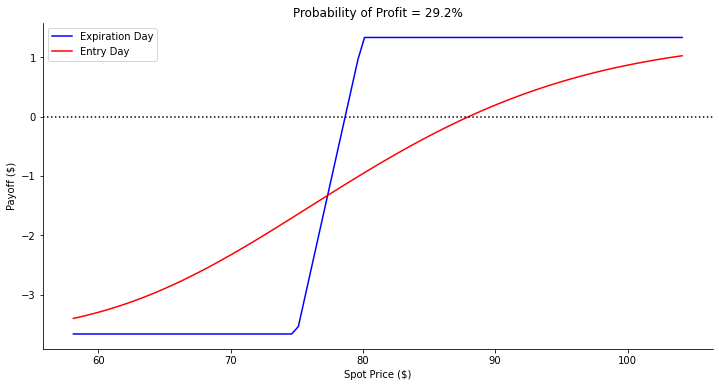

In [6]:
payoff = GetPayOff(Ticker, strike_price, entry_date, expiration, option_type, action)
payoff.plot_payoff()


#### 3. Actual Price and Volatility Moves

In [7]:
exit_date = datetime.datetime(2018, 5, 17)
bt1 = GetBackTesting(Ticker, strike_price, expiration, entry_date, exit_date, option_type, action)

#### 4. Returns

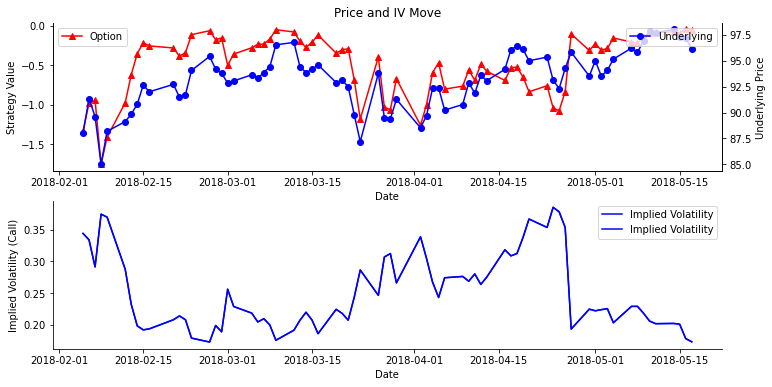

In [8]:
bt1.plot_price_history()

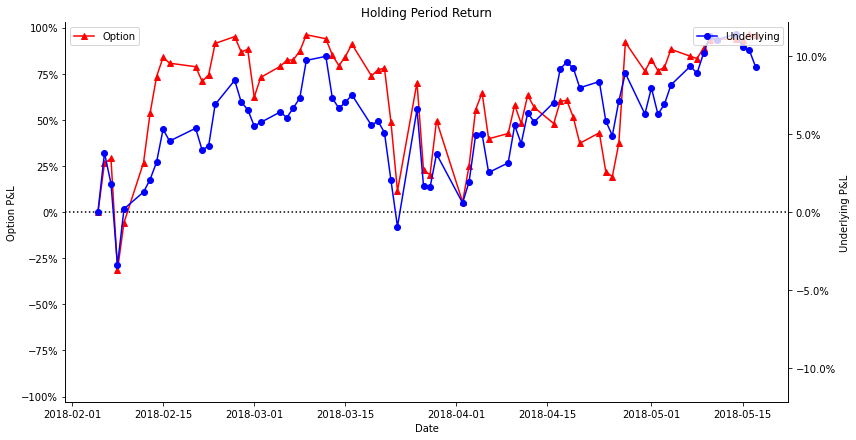

In [9]:
bt1.plot_option_pnl()

#### 5. Trade Journaling

In [10]:
bt1.strategy_summary

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2018-02-05,$-133.45,2018-05-17,101,$-5.29,$128.16,$1.27,96.0%,True


### IV. Recurring Strategy Setup
Get in when:
Simplified
* 1st trading day of every month
* Buy next month's expiration

Realistic:
* IV < 0
* Expiration date < 60 & Expiration date > 60
* VIX < 20

In [11]:
trading_days = GetDays(Ticker, Start_Date, End_Date, []).trading_days
trading_days['Year-Month'] = pd.to_datetime(trading_days['Date']).dt.to_period('M') + 1  # +1 to find the expiration date in the next month

dte_seeker = pd.merge(trading_days, expiry, on='Year-Month', how='left')
dte_seeker['DTE'] = (pd.to_datetime(dte_seeker['Expiration Date']) - pd.to_datetime(dte_seeker['Date'])).dt.days
dte_seeker.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


#### 43 DTE example

In [58]:
entry_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Date'].reset_index(drop=True))
expiration_dates = pd.to_datetime(dte_seeker[dte_seeker['DTE']==43]['Expiration Date'].reset_index(drop=True))
exit_dates = entry_dates + timedelta(days=25)
expiration_dates = pd.to_datetime(expiration_dates)
# exit_dates = dte_seeker[(dte_seeker['DTE']==21)]['Date']
# exit_dates[exit_dates>entry_dates[0]].reset_index(drop=True)

In [28]:
strategy_performance = pd.DataFrame([])
strat_sum_for_stats = []
strike_price = np.array(strike_price)
i = 0
for _ in entry_dates:
    bt = GetBackTesting(Ticker, strike_price, expiration_dates[i], entry_dates[i], exit_dates[i], option_type, action)
    strategy_performance = strategy_performance.append(bt.strategy_summary)
    strat_sum_for_stats.append(bt.strat_sum_for_stats)
    i += 1
    end_of_period_spot = bt.underlying_price_truncated_['close'][-1]
    strike_price = [end_of_period_spot-10, end_of_period_spot-5]
    
win_rate = "{:.2%}".format(strategy_performance['Win'].sum()/len(strategy_performance['Win']))
# Total_Cost = "${:,.2f}".format(strategy_performance['Cost Basis'].sum())

In [29]:
win_rate

'100.00%'

In [30]:
strategy_performance

,Entry Date,Cost Basis,Exit Date,Holding Period (Days),Residual Value,P&L,PnL/Day,ROC,Win
0,2017-01-05,$-225.80,2017-01-30,25,$-91.89,$133.91,$5.36,59.3%,True
0,2017-02-02,$-44.93,2017-02-27,25,$-7.22,$37.71,$1.51,83.9%,True
0,2017-03-16,$-0.82,2017-04-10,25,$-0.23,$0.59,$0.02,72.1%,True
0,2017-04-06,$-1.14,2017-05-01,25,$-0.02,$1.12,$0.04,98.6%,True


In [33]:
strategy_performance['P&L']

0    $133.91
0     $37.71
0      $0.59
0      $1.12
Name: P&L, dtype: object

In [56]:
pnl_sum =strategy_performance['P&L'].str.strip('$').astype(float).sum()
print('Total Profit: ', pnl_sum)

Total Profit:  173.33


In [ ]:
: